## Jupyter notebook to demonstrate the basic calibration setup

This notebook runs the following tasks:
* Create a test Visibility dataset.
   * Not adding visibility sample noise. Just testing that things are working exactly as expected.
   * Using the GLEAM sky model and a common everybeam station beam model.
   * Add complex Gaussian noise corruptions to station gains and leakage.
   * Impose a wavelength^2-dependent rotate on each station Jones matrix 
* Predict model visibilities (using GLEAM and everybeam).
* Do polarised bandpass calibration.
* Fit for the wavelength^2-dependent rotation of each station.
* Redo polarised bandpass calibration.

This notebook requires:
* See imports.

In [1]:
# Demonstration of basic calibration

# pylint cannot seem to handle astropy units
# pylint: disable=no-member

import importlib

# Imports
import warnings

import matplotlib.pyplot as plt
import numpy as np
import xarray
from astropy import constants as const
from astropy import units
from astropy.coordinates import Angle, SkyCoord

# from ska_sdp_func_python.calibration.operations import apply_gaintable
from ska_sdp_datamodels.calibration.calibration_create import (
    create_gaintable_from_visibility,
)
from ska_sdp_datamodels.configuration.config_create import (
    create_named_configuration,
)
from ska_sdp_datamodels.science_data_model import PolarisationFrame
from ska_sdp_datamodels.visibility.vis_create import create_visibility
from ska_sdp_func_python.preprocessing.flagger import rfi_flagger

from ska_sdp_instrumental_calibration.processing_tasks.beams import (
    GenericBeams,
)
from ska_sdp_instrumental_calibration.processing_tasks.calibration import (
    apply_gaintable,
    solve_bandpass,
)
from ska_sdp_instrumental_calibration.processing_tasks.lsm_tmp import (
    convert_model_to_skycomponents,
    generate_lsm,
)
from ska_sdp_instrumental_calibration.processing_tasks.predict import (
    predict_from_components,
)

warnings.simplefilter(action="ignore", category=FutureWarning)

<frozen abc>:106: FutureWarning: xarray subclass Visibility should explicitly define __slots__


In [2]:
# Helper functions (might move some to package)


def get_slice_lims(length, nslice):
    """Generate a list of slice index limits for n slices.

    Generate indices to slice a list into a number of equal-length slices.
    Allow the final slice to be smaller if need be.

    :param length: length of list to be sliced.
    """
    slice_lim0 = np.arange(0, length, int(np.ceil(length / nslice)))
    return np.stack((slice_lim0, np.append(slice_lim0[1:], length))).T

In [3]:
# Create a test Visibility dataset

# -------------------------------------------------------------------------- #
# Set up the array

# Read in an array configuration
low_config = create_named_configuration("LOWBD2")

# Down-select to a desired sub-array
#  - ECP-240228 modified AA2 clusters:
#      Southern Arm: S8 (x6), S9, S10 (x6), S13, S15, S16
#      Northern Arm: N8, N9, N10, N13, N15, N16
#      Eastern Arm: E8, E9, E10, E13.
#  - Most include only 4 of 6 stations, so just use the first 4:
AA2 = (
    np.concatenate(
        (
            345 + np.arange(6),  # S8-1:6
            351 + np.arange(4),  # S9-1:4
            429 + np.arange(6),  # S10-1:6
            447 + np.arange(4),  # S13-1:4
            459 + np.arange(4),  # S15-1:4
            465 + np.arange(4),  # S16-1:4
            375 + np.arange(4),  # N8-1:4
            381 + np.arange(4),  # N9-1:4
            471 + np.arange(4),  # N10-1:4
            489 + np.arange(4),  # N13-1:4
            501 + np.arange(4),  # N15-1:4
            507 + np.arange(4),  # N16-1:4
            315 + np.arange(4),  # E8-1:4
            321 + np.arange(4),  # E9-1:4
            387 + np.arange(4),  # E10-1:4
            405 + np.arange(4),  # E13-1:4
        )
    )
    - 1
)
mask = np.isin(low_config.id.data, AA2)
nstations = low_config.stations.shape[0]
low_config = low_config.sel(indexers={"id": np.arange(nstations)[mask]})

# Reset relevant station parameters
nstations = low_config.stations.shape[0]
low_config.stations.data = np.arange(nstations).astype("str")
low_config = low_config.assign_coords(id=np.arange(nstations))
# low_config.attrs["name"] = low_config.name+"-AA2"
low_config.attrs["name"] = "AA2-Low-ECP-240228"

print(f"Using {low_config.name} with {nstations} stations")

# -------------------------------------------------------------------------- #
# Set up the observation

# Set the phase centre in the ICRS coordinate frame
ra0 = Angle(0.0 * units.hourangle)
dec0 = Angle(-27.0 * units.deg)

# Set the parameters of sky model components
# chanwidth = 400e6 / 512  # station/CBF coarse channels = 781.25 kHz
chanwidth = 781.25e3  # Hz
nfrequency = 96
frequency = 781.25e3 * 128 + chanwidth * np.arange(nfrequency)
sample_time = 0.9  # seconds
solution_interval = sample_time  # would normally be minutes

# Set the phase centre hour angle range for the sim (in radians)
ha0 = 1 * np.pi / 12  # radians
ha = ha0 + np.arange(0, solution_interval, sample_time) / 3600 * np.pi / 12

# Create the Visibility dataset
vis = create_visibility(
    low_config,
    ha,
    frequency,
    channel_bandwidth=[chanwidth] * len(frequency),
    polarisation_frame=PolarisationFrame("linear"),
    phasecentre=SkyCoord(ra=ra0, dec=dec0),
    weight=1.0,
)

# Generate a true sky model and true visibilties for the whole band
gleamfile = "/data/EOS_1/mit183/gleamegc.dat"
fov = 10.0
flux_limit = 1
tsm = generate_lsm(
    gleamfile=gleamfile,
    phasecentre=vis.phasecentre,
    fov=fov,
    flux_limit=flux_limit,
)
ms_path = "/data/EOS_1/mit183/SKA/SP-4626/OSKAR_MOCK.ms"
%env EVERYBEAM_DATADIR=/data/EOS_1/mit183/SKA/SP-4626/ska-sdp-func-everybeam/coeffs
beams = GenericBeams(vis=vis, array="Low", ms_path=ms_path)

tsm_components = convert_model_to_skycomponents(tsm, vis.frequency.data)
predict_from_components(vis, tsm_components, beams=beams)

# Possible future development:
#  - Add thermal noise.
#  - Use the GSM package.
#  - Image-based sky models with degridding?
#  - Generate an ionospheric phase screen and add direction-dependent delays.
#  - Use the phase screen to add differential ionospheric Faraday rotation.

# Initially Jones matrices are 2x2 identity matrices
jones = create_gaintable_from_visibility(
    vis, jones_type="B", timeslice=solution_interval
)

# Add random complex antenna gain and leakage variations to the Jones matrices
g_sigma = 0.05
jones.gain.data += (
    np.random.normal(0, g_sigma, jones.gain.shape)
    + np.random.normal(0, g_sigma, jones.gain.shape) * 1j
)

# Multiply by ionospheric Faraday rotation
#  - Todo: rotate each component and each 5.4kHz channel separately
#  - Todo: use a phase screen. For now just have a gradient across the array
x = low_config.xyz.data[:, 0]
pp_rm = 1 + 6 * (x - np.min(x)) / (np.max(x) - np.min(x))
fr_mat = np.zeros((nstations, nfrequency, 2, 2))
lambda_sq = (const.c.value / frequency) ** 2
for stn in range(nstations):
    d_pa = pp_rm[stn] * lambda_sq
    fr_mat[stn] = np.stack(
        (np.cos(d_pa), -np.sin(d_pa), np.sin(d_pa), np.cos(d_pa)),
        axis=1,
    ).reshape(-1, 2, 2)
tmp = jones.gain.data.copy()
jones.gain.data = np.einsum("tsfpx,sfxq->tsfpq", tmp, fr_mat)

vis = apply_gaintable(vis=vis, gt=jones, inverse=False)

Using AA2-Low-ECP-240228 with 68 stations


2024-11-13 18:43:11,521 - ska_sdp_instrumental_calibration.processing_tasks.lsm_tmp - INFO - extracted 37 GLEAM components


env: EVERYBEAM_DATADIR=/data/EOS_1/mit183/SKA/SP-4626/ska-sdp-func-everybeam/coeffs
Could not load dataset for frequency 100 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 100 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 101 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 102 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 103 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 103 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 104 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 105 MHz, using the nearest neighbor with frequency 110 MHz instead
Could not load dataset for frequency 106 MHz, using the nearest neighbor with freque

In [4]:
# Do pre-processing

# Get the LSM (single call for all channels / dask tasks)
lsm = generate_lsm(
    gleamfile=gleamfile,
    phasecentre=vis.phasecentre,
    fov=fov,
    flux_limit=flux_limit,
)

%env EVERYBEAM_DATADIR=/data/EOS_1/mit183/SKA/SP-4626/ska-sdp-func-everybeam/coeffs
beams = GenericBeams(vis=vis, array="Low", ms_path=ms_path)

# Adapative RFI flagging (assume known flags/birdies have been applied)
#  - Could also use dask parallelism.
#  - Should have already been done in the batch pre-processing pipeline
# This works but requires ska_sdp_func:
if importlib.util.find_spec("ska_sdp_func") is not None:
    print("Calling ska_sdp_func_python preprocessing flagger rfi_flagger")
    vis = rfi_flagger(vis)
else:
    print("ska_sdp_func is not available for rfi flagging")

# Chunking of Visibility dataset in frequency

# Set a number of "parallel dask tasks" to divide calibration between
#  - There is no dask. Each "task" is done sequentially.
ndasktask = 6

# Averaging of Visibility datasets in time or frequency.
#  - Presumably use dask parallelism.
#  - Done as part of chunking?

2024-11-13 18:43:18,237 - ska_sdp_instrumental_calibration.processing_tasks.lsm_tmp - INFO - extracted 37 GLEAM components


env: EVERYBEAM_DATADIR=/data/EOS_1/mit183/SKA/SP-4626/ska-sdp-func-everybeam/coeffs
Calling ska_sdp_func_python preprocessing flagger rfi_flagger


In [5]:
# Predict model visibilities

# Could do this inside the bandpass calibration area, parallel by subband.
# But keep it separate to test that:
#  - it can be done in another workflow (e.g. in pre-processing)
#  - accelerators can be used

# Create an empty model Visibility dataset
#  - Is it better to generate separate sub-band datasets and then concatenate?
#     - It is presumably faster to allocate the xarray sub-bands in parallel.
#     - If they have frequency chunking anyway, perhaps concat is efficient...
#  - Want frequency chuncking, so copy rather than calling create_visibility?
#     - Seems reasonable, but may want to duplicate pre-proc time and
#       frequency averaging if there is appreciable decorrelation. In which
#       case this would need to be done before pre-precessing.
modelvis = vis.assign({"vis": xarray.zeros_like(vis.vis)})
assert np.all(modelvis.vis.data == 0)

print(
    "full spectral range: "
    + f"{np.min(modelvis.frequency.data)/1e6:.4f} - "
    + f"{np.max(modelvis.frequency.data)/1e6:.4f} MHz"
)

nchan = 0
for dasktask, slice_lims in enumerate(get_slice_lims(nfrequency, ndasktask)):
    # Create an xarray view for the current sub-band
    bandmodel = modelvis.isel(frequency=slice(slice_lims[0], slice_lims[1]))
    nchan += len(bandmodel.frequency)
    print(
        "band spectral range: "
        + f"{np.min(bandmodel.frequency.data)/1e6:.4f} - "
        + f"{np.max(bandmodel.frequency.data)/1e6:.4f} MHz "
        + f"(dask task {dasktask}, nchan = {len(bandmodel.frequency)})"
    )

    # Put a point source at phase centre
    lsm_components = convert_model_to_skycomponents(
        lsm, bandmodel.frequency.data, freq0=200e6
    )
    bandmodel = predict_from_components(bandmodel, lsm_components, beams=beams)

assert len(modelvis.frequency) == nchan

# Make sure modelvis was updated
#  - i.e. ensure that the isel in predict used reference semantics
assert not np.all(
    modelvis.vis.data == 0
), "bandmodel view updates should have changed this"

full spectral range: 100.0000 - 174.2188 MHz
band spectral range: 100.0000 - 111.7188 MHz (dask task 0, nchan = 16)
band spectral range: 112.5000 - 124.2188 MHz (dask task 1, nchan = 16)
band spectral range: 125.0000 - 136.7188 MHz (dask task 2, nchan = 16)
band spectral range: 137.5000 - 149.2188 MHz (dask task 3, nchan = 16)
band spectral range: 150.0000 - 161.7188 MHz (dask task 4, nchan = 16)
band spectral range: 162.5000 - 174.2188 MHz (dask task 5, nchan = 16)


In [6]:
# Do the polarised bandpass calibration
#  - Currently taking a long time because some channels are not converging.
#     - Presumably related to the rotations.
#     - Should be able to initialise the solutions better.

# Create a full-band bandpass calibration gain table
#  - It may be easier to do this in each sub-band then concatenate...
gaintable = create_gaintable_from_visibility(
    vis, jones_type="B", timeslice=solution_interval
)

assert len(gaintable.time) == 1

refant = 0

for dasktask, slice_lims in enumerate(get_slice_lims(nfrequency, ndasktask)):
    # Create xarray views for the current sub-band
    bandvis = vis.isel(frequency=slice(slice_lims[0], slice_lims[1]))
    bandmodel = modelvis.isel(frequency=slice(slice_lims[0], slice_lims[1]))
    # This assumes that the same slicing is used for the table. The solver
    # allows for each task to also combine the data into a single solution for
    # all channels, to generate solutions at the task sub-band resolution.
    # Would need to generalise this selection though.
    bandtable = gaintable.isel(frequency=slice(slice_lims[0], slice_lims[1]))
    print(
        "band spectral range: "
        + f"{np.min(bandmodel.frequency.data)/1e6:.4f} - "
        + f"{np.max(bandmodel.frequency.data)/1e6:.4f} MHz "
        + f"(dask task {dasktask}, nchan = {len(bandmodel.frequency)})"
    )

    # Call bandpass calibration function for this sub-band.
    #  - bandtable should either have a single solution spectral channel or
    #    one for each input channel. Here it is the latter.
    #  - Internally, the bandpass calibration function might call solvers
    #    multiple times.
    #  - The bandpass calibration function should return a list of bad
    #    antennas and bad channels, as well as other QA data.
    #  - Solver types:
    #      “gain_substitution”
    #      “jones_substitution”
    #      “normal_equations”
    #      “normal_equations_presum”

    solve_bandpass(
        vis=bandvis,
        modelvis=bandmodel,
        gain_table=bandtable,
        solver="normal_equations",
        refant=refant,
    )

    # catch "failed to converge" warnings and set temporary flags?

# Do some phase referencing for comparisons
inputdata = jones.gain.data * np.exp(
    -1j
    * np.angle(
        jones.gain.data[:, [refant], :, 0, 0][..., np.newaxis, np.newaxis]
    )
)
gaintable.gain.data *= np.exp(
    -1j
    * np.angle(
        gaintable.gain.data[:, [refant], :, 0, 0][..., np.newaxis, np.newaxis]
    )
)

# Don't expect all channels to pass:
# assert np.all(np.isclose(gaintable.gain.data, inputdata))

band spectral range: 100.0000 - 111.7188 MHz (dask task 0, nchan = 16)


_normal_equation_solve: gain solutions failed to converge for channel 2
_normal_equation_solve: gain solutions failed to converge for channel 4
_normal_equation_solve: gain solutions failed to converge for channel 8
_normal_equation_solve: gain solutions failed to converge for channel 11
_normal_equation_solve: gain solutions failed to converge for channel 12


band spectral range: 112.5000 - 124.2188 MHz (dask task 1, nchan = 16)


_normal_equation_solve: gain solutions failed to converge for channel 6
_normal_equation_solve: gain solutions failed to converge for channel 7
_normal_equation_solve: gain solutions failed to converge for channel 13


band spectral range: 125.0000 - 136.7188 MHz (dask task 2, nchan = 16)


_normal_equation_solve: gain solutions failed to converge for channel 7
_normal_equation_solve: gain solutions failed to converge for channel 13


band spectral range: 137.5000 - 149.2188 MHz (dask task 3, nchan = 16)


_normal_equation_solve: gain solutions failed to converge for channel 5
_normal_equation_solve: gain solutions failed to converge for channel 8
_normal_equation_solve: gain solutions failed to converge for channel 10
_normal_equation_solve: gain solutions failed to converge for channel 15


band spectral range: 150.0000 - 161.7188 MHz (dask task 4, nchan = 16)


_normal_equation_solve: gain solutions failed to converge for channel 5
_normal_equation_solve: gain solutions failed to converge for channel 6
_normal_equation_solve: gain solutions failed to converge for channel 14


band spectral range: 162.5000 - 174.2188 MHz (dask task 5, nchan = 16)


_normal_equation_solve: gain solutions failed to converge for channel 2
_normal_equation_solve: gain solutions failed to converge for channel 7
_normal_equation_solve: gain solutions failed to converge for channel 11
_normal_equation_solve: gain solutions failed to converge for channel 13


In [7]:
def extract_rm(jones, lambda_sq, normalise=False):
    """Fit a rotation measure spectrum for each station Jones.

    For each station, the Jones matrix for each channel is used to
    operate on a unit vector. The result is expressed as a complex
    number, and the spectrum of complex numbers is the Fourier
    transformed with respect to wavelength squared. The peaks of this
    transformed spectrum is taken as the rotation measure for the
    stations.

    This function needs to be cleaned up, documented and added to the
    repository.
    """
    # reference against a single station
    ref = 0

    # fr_mat = np.zeros((nstations, nfrequency, 2, 2))
    nstations = jones.shape[1]
    assert jones.shape[2] == len(lambda_sq)

    oversample = 5
    rm_res = 1 / oversample / (np.max(lambda_sq) - np.min(lambda_sq))
    rm_max = 1 / (lambda_sq[-2] - lambda_sq[-1])
    # rm_vals = np.arange(0, rm_max, rm_res)
    rm_vals = np.arange(-rm_max, rm_max, rm_res)
    uvec = np.array([1, 0])
    rm_peeks = np.zeros(nstations)
    oneonN = 1 / len(frequency)
    for stn in range(nstations):
        # Reference against a single station
        ag_mat = np.einsum("fpx,fqx->fpq", jones[0, stn], jones[0, ref].conj())
        # Normalise?
        if normalise:
            ag_norm = np.linalg.norm(ag_mat, axis=(1, 2)) / np.sqrt(2)
            fr_mat = np.einsum("fpq,f->fpq", ag_mat, 1 / ag_norm)
        else:
            fr_mat = ag_mat
        # Rotate a unit vector per channel
        rvec = np.einsum("fpq,q->fp", fr_mat, uvec)
        # Express the results as a complex numbers
        f_spec = rvec[:, 0] + 1j * rvec[:, 1]
        # Take the RM transform of the complex numbers and find the peak
        rm_spec = oneonN * np.einsum(
            "rf,f->r", np.exp(np.outer(-1j * rm_vals, lambda_sq)), f_spec
        )

        # Only bother if peak is significant. TODO: What is significant?
        if np.max(np.abs(rm_spec)) > 0.5:
            rm_peeks[stn] = rm_vals[np.argmax(np.abs(rm_spec))]

        if stn == nstations - 5:
            plt.figure()
            ax = plt.subplot(111)
            ax.plot(rm_vals, np.abs(rm_spec), "b", label="abs")
            ax.plot(rm_vals, np.real(rm_spec), "c", label="re")
            ax.plot(rm_vals, np.imag(rm_spec), "m", label="im")
            ax.plot((pp_rm[stn] - pp_rm[0]) * np.ones(2), ax.get_ylim(), "r")
            ax.plot(rm_peeks[stn] * np.ones(2), ax.get_ylim(), "b--")
            ax.set_xlim((-7, 7))
            ax.grid()
            ax.legend()

    return rm_peeks


[ 0.      0.0014  0.0056  0.0069  0.1843  0.1827  0.1879  0.1797 -0.9981 -1.0048 -1.0059 -1.0018 -1.0071 -0.9957
 -0.785  -0.7798 -0.7785 -0.7836 -0.7372 -0.7289 -0.7326 -0.7369 -1.1298 -1.1357 -1.1373 -1.1402  0.2823  0.2924
  0.2874  0.2956  1.5773  1.5771  1.5785  1.5855 -1.447  -1.4523 -1.4469 -1.4539 -1.4471 -1.4418 -1.9247 -1.9297
 -1.9253 -1.92   -0.9418 -0.9344 -0.9421 -0.9394 -1.0644 -1.0683 -1.0614 -1.0646 -0.5994 -0.594  -0.6042 -0.5955
 -1.6113 -1.6165 -1.6166 -1.6109 -3.2722 -3.2742 -3.2785 -3.2659 -4.4137 -4.4145 -4.4112 -4.4079]

[ 0.      0.      0.      0.      0.1659  0.1991  0.1991  0.2655 -0.9956 -1.0288 -0.9956 -0.9956 -1.0288 -0.9956
 -0.7633 -0.7633 -0.7633 -0.7965 -0.7301 -0.7633 -0.7633 -0.7301 -1.1284 -1.1615 -1.0952 -1.1615  0.2655  0.3319
  0.2987  0.2655  1.593   1.593   1.593   1.593  -1.4602 -1.427  -1.427  -1.4602 -1.4602 -1.427  -1.8917 -1.9248
 -1.958  -1.958  -0.9624 -0.9624 -0.9624 -0.9292 -1.062  -1.0952 -1.0952 -1.0952 -0.5974 -0.5974 -0.5974 -0.5

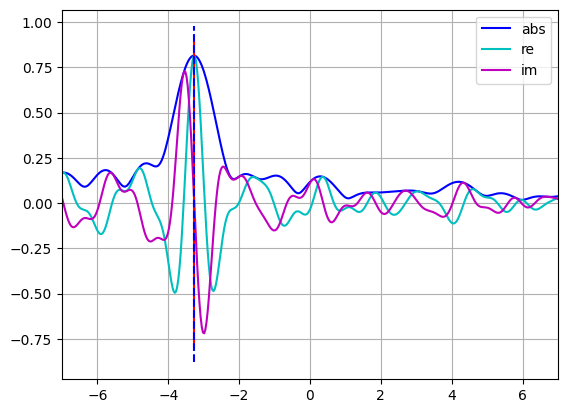

In [8]:
# Fit a rotation measure spectrum for each station Jones.

rm_update = extract_rm(gaintable.gain.data, lambda_sq, normalise=True)

print()
print(pp_rm - pp_rm[0])
print()
print(rm_update - rm_update[0])

In [9]:
# initialise gain table with rotation fits and retry calibration

newtable = create_gaintable_from_visibility(
    vis, jones_type="B", timeslice=solution_interval
)
for stn in range(nstations):
    d_pa = rm_update[stn] * lambda_sq
    newtable.gain.data[0, stn] = np.stack(
        (np.cos(d_pa), -np.sin(d_pa), np.sin(d_pa), np.cos(d_pa)),
        axis=1,
    ).reshape(-1, 2, 2)

for dasktask, slice_lims in enumerate(get_slice_lims(nfrequency, ndasktask)):
    # Create xarray views for the current sub-band
    bandvis = vis.isel(frequency=slice(slice_lims[0], slice_lims[1]))
    bandmodel = modelvis.isel(frequency=slice(slice_lims[0], slice_lims[1]))
    bandtable = newtable.isel(frequency=slice(slice_lims[0], slice_lims[1]))
    print(
        "band spectral range: "
        + f"{np.min(bandmodel.frequency.data)/1e6:.4f} - "
        + f"{np.max(bandmodel.frequency.data)/1e6:.4f} MHz "
        + f"(dask task {dasktask}, nchan = {len(bandmodel.frequency)})"
    )

    solve_bandpass(
        vis=bandvis,
        modelvis=bandmodel,
        gain_table=bandtable,
        solver="normal_equations",
        refant=refant,
    )

# Do some phase referencing for comparisons
inputdata = jones.gain.data * np.exp(
    -1j
    * np.angle(
        jones.gain.data[:, [refant], :, 0, 0][..., np.newaxis, np.newaxis]
    )
)
newtable.gain.data *= np.exp(
    -1j
    * np.angle(
        newtable.gain.data[:, [refant], :, 0, 0][..., np.newaxis, np.newaxis]
    )
)

assert np.all(np.isclose(newtable.gain.data, inputdata))

band spectral range: 100.0000 - 111.7188 MHz (dask task 0, nchan = 16)
band spectral range: 112.5000 - 124.2188 MHz (dask task 1, nchan = 16)
band spectral range: 125.0000 - 136.7188 MHz (dask task 2, nchan = 16)
band spectral range: 137.5000 - 149.2188 MHz (dask task 3, nchan = 16)
band spectral range: 150.0000 - 161.7188 MHz (dask task 4, nchan = 16)
band spectral range: 162.5000 - 174.2188 MHz (dask task 5, nchan = 16)
